# Library Used

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error,mean_absolute_error
from fpdf import FPDF

# Read CSV File

In [37]:
# Step 1: Read the CSV file into a Pandas DataFrame
# 'malaysia2.csv' is the file containing your data. It is read into a DataFrame using the `read_csv` function.
data = pd.read_csv ('malaysia2.csv')

# Step 2: Convert the 'Date' column to a datetime format
# The 'Date' column in the CSV file is likely a string, so we convert it to a datetime object using `pd.to_datetime()`.
# This ensures that the column is properly recognized as a date/time data type, which is necessary for time series analysis.
data['Date'] = pd.to_datetime(data['Date'])

# Step 3: Set the 'Date' column as the index of the DataFrame
# After converting the 'Date' column to datetime, we set it as the index of the DataFrame using `set_index()`.
# This makes it easier to work with time series data, as the index now represents the date of each observation.
data.set_index('Date', inplace=True)

# Linear Regression

In [38]:
# Linear Regression

# Step 1: Prepare the data for Linear Regression
# Convert the datetime index to ordinal values (numerical representation of dates) 
# because Linear Regression requires numerical inputs.
# Each date is converted to an ordinal using .toordinal(), representing days since 01-Jan-0001.
X_lr = data.index.to_series().apply(lambda x: x.toordinal()).values.reshape(-1, 1) # Reshape to 2D array for compatibility with the model

# Extract the target variable (Parcel Volume) as a numpy array
y_lr = data['Parcel Volume'].values

# Step 2: Create and train the Linear Regression model
# Instantiate a Linear Regression model
regression_lr = LinearRegression()

# Fit the model to the data (ordinal dates as X and Parcel Volume as y)
regression_lr.fit(X_lr, y_lr)

# Step 3: Make predictions on the input data
# Use the trained model to predict Parcel Volume for the given dates (X_lr)
y_lr_pred = regression_lr.predict(X_lr)

# ARIMA

In [39]:
# ARIMA

# Step 1: Define the ARIMA model
# ARIMA (AutoRegressive Integrated Moving Average) is used for time series forecasting.
# - The input data is the target variable 'Parcel Volume'.
# - 'order=(2, 0, 2)' specifies the model parameters:
#   * 2: The number of lag observations to include (AR - AutoRegressive part).
#   * 0: The degree of differencing required to make the series stationary (I - Integrated part).
#   * 2: The size of the moving average window (MA - Moving Average part).
model_arima = ARIMA(data['Parcel Volume'], order=(2, 0, 2))

# Step 2: Fit the ARIMA model to the data
# Fit the defined ARIMA model to the 'Parcel Volume' time series data.
# This step estimates the parameters of the model.
model_fit = model_arima.fit()

# Step 3: Generate predictions
# Predict future values of the series using the fitted ARIMA model.
# - 'start' defines the beginning of the prediction period (e.g., '2022-01-01').
# - 'end' specifies the end of the prediction period (e.g., '2024-03-01').
# These should be within or slightly beyond the range of the original dataset.
predictions_arima = model_fit.predict(start='2022-01-01', end='2024-03-01')

C:\Users\fiqxq\anaconda3\envs\ForcastPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fiqxq\anaconda3\envs\ForcastPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fiqxq\anaconda3\envs\ForcastPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Random Forest Regressor

In [40]:
# Random Forest Regressor

# Step 1: Prepare the data for the Random Forest model
# Convert the datetime index to ordinal values (numerical representation of dates) 
# because Random Forest requires numerical inputs.
# Each date is converted to an ordinal using .toordinal(), which represents days since 01-Jan-0001.
X_rf = data.index.to_series().apply(lambda x: x.toordinal()).values.reshape(-1, 1)  # Reshape to a 2D array for model compatibility

# Extract the target variable (Parcel Volume) as a numpy array
y_rf = data['Parcel Volume'].values

# Step 2: Create and train the Random Forest model
# Instantiate the Random Forest Regressor
# - n_estimators=100 specifies the number of trees in the forest
# - random_state=42 ensures reproducibility of the results
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the data (ordinal dates as X and Parcel Volume as y)
rf_model.fit(X_rf, y_rf)

# Step 3: Make predictions on the same input data
# Use the trained model to predict Parcel Volume for the given dates (X_rf)
predictions_rf = rf_model.predict(X_rf)

# Prophet

In [41]:
# Prophet

# Step 1: Prepare data for Prophet model
# Prophet requires the input data to have two specific column names:
# 'ds' for the datetime column and 'y' for the target variable (to predict).
data_prophet = data.reset_index().rename(columns={'Date': 'ds', 'Parcel Volume': 'y'})

# Step 2: Create and train the Prophet model
# Instantiate a Prophet model instance
model_prophet = Prophet()

# Fit the model to the prepared data (ds and y columns)
model_prophet.fit(data_prophet)

# Step 3: Generate future dates for predictions
# Make a future dataframe extending the time range by 16 months (16 periods with a frequency of 'M')
future_dates = model_prophet.make_future_dataframe(periods=16, freq='M')

# Step 4: Forecast future values
# Predict future values based on the model and the extended dataframe
forecast = model_prophet.predict(future_dates)

# Step 5: Extract relevant predictions
# Retrieve the last 9 predictions (tail(9)) with 'ds' (date) and 'yhat' (predicted value),
# rounding the predictions to the nearest integer for clarity
predictions_prophet = forecast[['ds', 'yhat']].tail(9).round(0)

11:31:55 - cmdstanpy - INFO - Chain [1] start processing
11:31:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\fiqxq\anaconda3\envs\ForcastPython\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


# Plot Graph

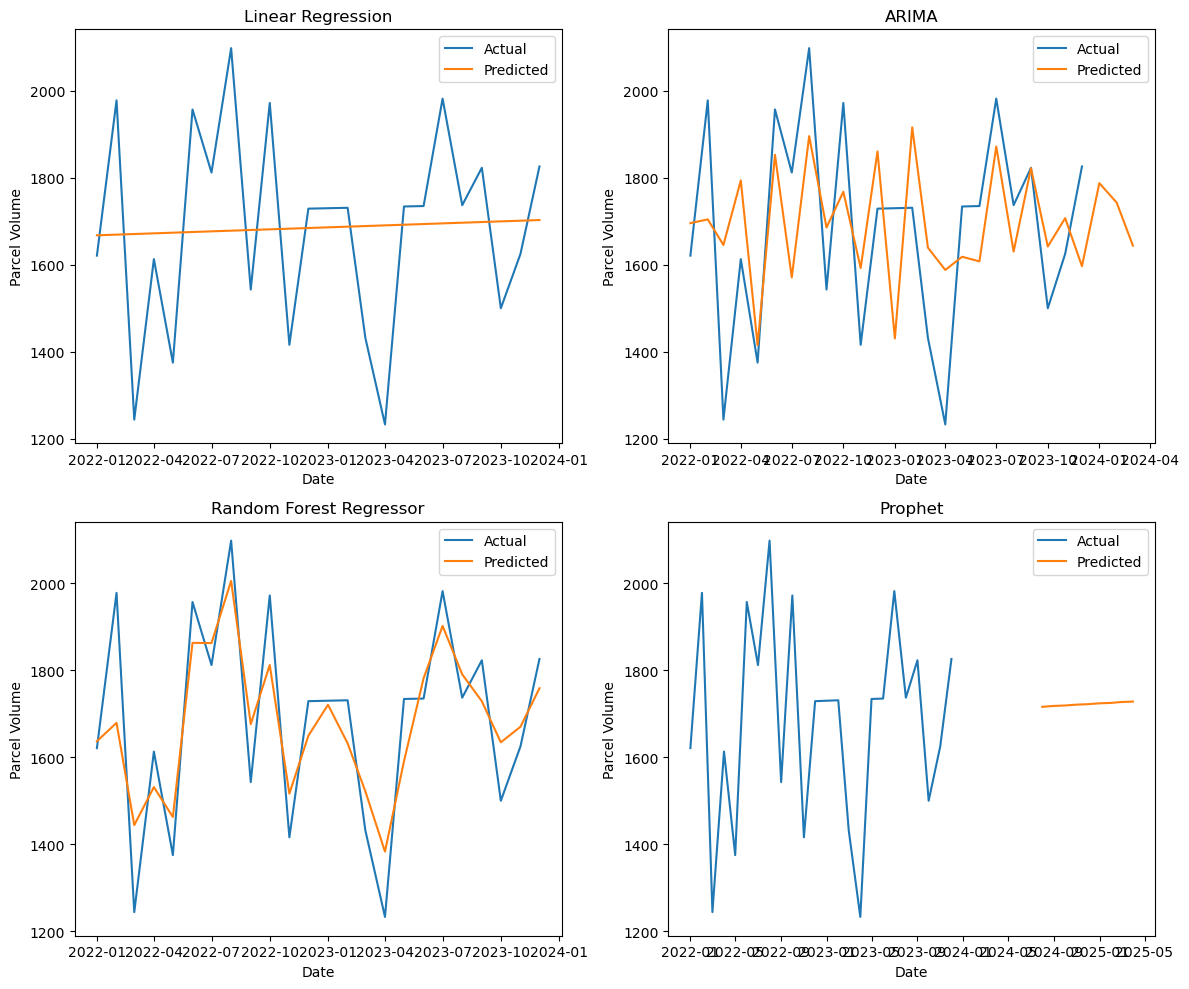

In [42]:
fiq, axs = plt.subplots(2,2, figsize=(12,10))
# Linear Regression
axs[0, 0].plot(data.index, data['Parcel Volume'], label='Actual')
axs[0, 0].plot(data.index, y_lr_pred, label='Predicted')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Parcel Volume')
axs[0, 0].legend()

# ARIMA
axs[0, 1].plot(data['Parcel Volume'], label='Actual')
axs[0, 1].plot(predictions_arima, label='Predicted')
axs[0, 1].set_title('ARIMA')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Parcel Volume')
axs[0, 1].legend()

# Random Forest Regressor
axs[1, 0].plot(data.index, data['Parcel Volume'], label='Actual')
axs[1, 0].plot(data.index, predictions_rf, label='Predicted')
axs[1, 0].set_title('Random Forest Regressor')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Parcel Volume')
axs[1, 0].legend()

# Prophet
axs[1, 1].plot(data_prophet['ds'], data_prophet['y'], label='Actual')
axs[1, 1].plot(predictions_prophet['ds'], predictions_prophet['yhat'], label='Predicted')
axs[1, 1].set_title('Prophet')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Parcel Volume')
axs[1, 1].legend()

# Adjust the layout
plt.tight_layout()
 
# Save the plot as an image
plt.savefig('parcel_volume_forecasting_graphs.png')

In [43]:
# Calculate MSE and MAE for each model
mse_lr = mean_squared_error(data['Parcel Volume'], y_lr_pred)
mae_lr = mean_absolute_error(data['Parcel Volume'], y_lr_pred)
 
# Option 1: Trim predictions to match the true values
predictions_arima_trimmed = predictions_arima[:24]
 
# Then calculate metrics
mse_arima = mean_squared_error(data['Parcel Volume'].loc['2022-01-01':'2024-01-01'], predictions_arima_trimmed)
mae_arima = mean_absolute_error(data['Parcel Volume'].loc['2022-01-01':'2024-01-01'], predictions_arima_trimmed)
 
mse_rf = mean_squared_error(data['Parcel Volume'], predictions_rf)
mae_rf = mean_absolute_error(data['Parcel Volume'], predictions_rf)
 
mse_prophet = mean_squared_error(data_prophet['y'].tail(9), predictions_prophet['yhat'].tail(9))
mae_prophet = mean_absolute_error(data_prophet['y'].tail(9), predictions_prophet['yhat'].tail(9))

In [44]:
# Generate PDF report
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'K-Youth Algorithm Report - Parcel Volume', ln=True, align='C')
        self.ln(10)
 
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, 'Page ' + str(self.page_no()), 0, 0, 'C')

In [45]:
# Create PDF document
pdf = PDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

C:\Users\fiqxq\AppData\Local\Temp\ipykernel_14104\3744501376.py:4: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  self.set_font('Arial', 'B', 12)
C:\Users\fiqxq\AppData\Local\Temp\ipykernel_14104\3744501376.py:5: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 10, 'K-Youth Algorithm Report - Parcel Volume', ln=True, align='C')


In [46]:
# Report Title
pdf.set_font('Arial', 'B', 16)
pdf.cell(200, 10, txt="Parcel Volume Forecasting", ln=True, align='C')
pdf.ln(10)
 
# Section 1: Introduction
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="1. Introduction", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="In this report, we analyze the parcel volume data to forecast future trends using multiple machine learning techniques including Linear Regression, ARIMA, Random Forest Regressor, and Prophet. The data used spans several years, and the goal is to provide a reliable forecast based on the model performances.")
 
pdf.ln(5)
 
# Section 2: Data Overview
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="2. Data Overview", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="The dataset contains parcel volume data over time. The dataset was preprocessed and time-indexed to make it suitable for time-series forecasting. Date values were converted to ordinal integers for models requiring numerical input.")
 
pdf.ln(5)
 
# Section 3: Modeling Techniques
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="3. Modeling Techniques", ln=True)
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="3.1 Linear Regression", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="Linear Regression is a basic and interpretable model that attempts to capture the linear relationship between the time index and the parcel volume. This model is straightforward, but may not capture complex patterns in time-series data.")
 
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="3.2 ARIMA", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="ARIMA is a popular statistical method for time-series forecasting that captures both trend and seasonality. In this case, we used an ARIMA(2,0,2) model to capture the relationships in the parcel volume data.")
 
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="3.3 Random Forest Regressor", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="The Random Forest Regressor is an ensemble learning method that can capture complex non-linear relationships. By using multiple decision trees, it can provide robust predictions, especially in diverse datasets.")
 
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="3.4 Prophet", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="Prophet is a forecasting tool designed for business time-series data. It is robust to missing data and shifts in the trend, and it automatically detects seasonal patterns.")
 
# Section 4: Model Evaluation
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="4. Model Evaluation", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="The performance of the models was evaluated using Mean Squared Error (MSE) and Mean Absolute Error (MAE). The results are as follows:")
 
# Evaluation metrics
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="Linear Regression", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt=f"MSE: {mse_lr:.2f}, MAE: {mae_lr:.2f}")
 
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="ARIMA", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt=f"MSE: {mse_arima:.2f}, MAE: {mae_arima:.2f}")
 
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="Random Forest Regressor", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt=f"MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}")
 
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="Prophet", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt=f"MSE: {mse_prophet:.2f}, MAE: {mae_prophet:.2f}")
 
# Add graphs to PDF
pdf.add_page()
pdf.image('parcel_volume_forecasting_graphs.png', x=10, y=30, w=190)  # Adjust x and y as necessary
 
# Section 5: Conclusion
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="5. Conclusion", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="Based on the evaluation metrics, we observe that each model has its strengths and weaknesses. The Random Forest Regressor shows promise in capturing non-linear relationships, while ARIMA provides a good fit for time series with trend and seasonality. The choice of model may depend on the specific requirements of accuracy, interpretability, and computational resources.")
 
# Save PDF
pdf.output('parcel_volume_forecasting_report.pdf')
 
print("PDF report generated successfully.")

C:\Users\fiqxq\AppData\Local\Temp\ipykernel_14104\200151117.py:2: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font('Arial', 'B', 16)
C:\Users\fiqxq\AppData\Local\Temp\ipykernel_14104\200151117.py:3: DeprecationWarning: The parameter "txt" has been renamed to "text" in 2.7.6
  pdf.cell(200, 10, txt="Parcel Volume Forecasting", ln=True, align='C')
C:\Users\fiqxq\AppData\Local\Temp\ipykernel_14104\200151117.py:3: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(200, 10, txt="Parcel Volume Forecasting", ln=True, align='C')
C:\Users\fiqxq\AppData\Local\Temp\ipykernel_14104\200151117.py:7: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font('Arial', 'B', 14)
C:\Users\fiqxq\AppData\Local\Temp\ipykernel_14104\200151117.py:8: D

PDF report generated successfully.
